In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt

class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = []
        self.dPre = []
        self.dPost= []
        self.dv   = []
        self.dDK  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.iStart = None
        self.iStop  = None
    
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)         
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
    
    def vSetDiscount(self,fIRate):
        vTemp = 1./(1.+fIRate)
        #print("Discount %.4f"%(vTemp))
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])
    
    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.mat(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.mat(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "   %10.4f  "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)
        
    def PlotCFs(self,iStart,iStop,figNr=2):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetCF(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)
        
    def PlotTontine(self,iStart,iStop,figNr=3,bChatter = False):
        iStartState = 0
        iNrStates = self.iNrStates
        x=[]
        y=[]
        A = np.mat(np.eye(iNrStates))
        for i in range(iStop, iStart):
            R=0
            Denom =0.
            for j in range(self.iNrStates-1):
                RPART = A[iStartState,j] * (self.iNrStates-1.)/(self.iNrStates-1.-j)
                if bChatter:
                    print("%3d/%3d: D %6.2f. RPart %6.2f RTot %6.2f" %(i,j,Denom,A[iStartState,j] * (self.iNrStates-1.)/(self.iNrStates-1.-j),R))
                    print("RPART: P[i, j] %7.4f  TL %3d AL %3d --> %7.4f"%(A[iStartState,j],(self.iNrStates-1.),(self.iNrStates-1.-j),RPART))
                R+=A[iStartState,j] * (self.iNrStates-1.)/(self.iNrStates-1.-j)
                Denom += A[iStartState,j]
            R /= Denom  
            if bChatter:
                print("%3d/%3d: D %6.2f. RPart %6.2f RTot %6.2f" %(i,j,Denom,A[iStartState,j] * (self.iNrStates-1.)/(self.iNrStates-1.-j),R))
               
            y.append(R)
            x.append(i)
            A = A * np.mat(self.dPij[i])
        plt.figure(figNr)
        plt.plot(x,y,'-r')
        plt.grid(True)       
        
        
def mu(x):
    return(np.exp(-9.13275+0.0809*x+0.000011*x*x))

                            
    

def Tontine(nPeople, Age = 10, dIrate = 0.02, bPrintDK = False, bChatter = False):
    symM = Markov()
    nStates = 2**nPeople
    symM.vDefineModel(nStates)
    symM.vSetDiscount(dIrate)
    iStart = 110
    iStop = Age

    PowerStack  = []
    for l in range(nPeople):
        PowerStack.append(2**l)
    
    for i in range(iStop,iStart):
        qx = mu(i)
        if i % 5 == 0:
            print("Prep Age %d --> qx %7.4f"%(i,qx))
        for j in range(nStates):
            for k in range(nStates):
                currentP = 1.
                for l in range(nPeople):
                    dFactor = 0.
                    bitVon = j & PowerStack[l]
                    bitNach = k & PowerStack[l]
                    if bitVon == 0 and bitNach == 0: dFactor = 1.
                    if bitVon != 0 and bitNach == 0: dFactor = qx
                    if bitVon != 0 and bitNach != 0: dFactor = 1. - qx
                    currentP *= dFactor
                if bChatter: print(i,j,k,currentP)
                symM.vSetPij(i,j,k,currentP)
            dNrRentner = 0.
            for l in range(nPeople):
                bitVon = j & PowerStack[l]
                if bitVon != 0:
                    dNrRentner += 1.
            if bChatter: print(i,j,dNrRentner)
            symM.vSetPre(i,j,0,dNrRentner)
        
    if bPrintDK: symM.PrintDKs(iStart,iStop)
    print("Plot DK")
    symM.PlotDKs(iStart,iStop)
    print("Plot CF")
    symM.PlotCFs(iStart,iStop)  
    return(symM)

def Tontine2(nPeople, Age = 10, dIrate = 0.02, bPrintDK = False, bChatter = False):
    symM = Markov()
    nStates = nPeople+1
    symM.vDefineModel(nStates)
    symM.vSetDiscount(dIrate)
    iStart = 110
    iStop = Age

    for i in range(iStop,iStart):
        qx = mu(i)
        for j in range(nStates):
            for k in range(j,nStates):
                dead = k-j
                surv = (nStates-j)-dead
                dFact = scipy.special.binom(surv+dead, surv) * (1-qx)**(surv) * qx**(dead)
                if bChatter: print(i,j,k,qx,surv, dead,scipy.special.binom(surv+dead, surv), dFact)
                symM.vSetPij(i,j,k,dFact)
            dNrRentner = nStates-j-1
            if bChatter: print(i,j,dNrRentner)
            symM.vSetPre(i,j,0,dNrRentner)
            symM.vSetPij(i,nStates-1,nStates-1,1)
        
    if bPrintDK: symM.PrintDKs(iStart,iStop)
    print("Plot DK")
    symM.PlotDKs(iStart,iStop)
    print("Plot CF")
    symM.PlotCFs(iStart,iStop) 
    symM.PlotTontine(iStart,iStop)
    return(symM)

Prep Age 10 --> qx  0.0002
Prep Age 15 --> qx  0.0004
Prep Age 20 --> qx  0.0005
Prep Age 25 --> qx  0.0008
Prep Age 30 --> qx  0.0012
Prep Age 35 --> qx  0.0019
Prep Age 40 --> qx  0.0028
Prep Age 45 --> qx  0.0042
Prep Age 50 --> qx  0.0063
Prep Age 55 --> qx  0.0096
Prep Age 60 --> qx  0.0144
Prep Age 65 --> qx  0.0218
Prep Age 70 --> qx  0.0328
Prep Age 75 --> qx  0.0496
Prep Age 80 --> qx  0.0750
Prep Age 85 --> qx  0.1134
Prep Age 90 --> qx  0.1716
Prep Age 95 --> qx  0.2598
Prep Age 100 --> qx  0.3935
Prep Age 105 --> qx  0.5963
Plot DK
Plot CF


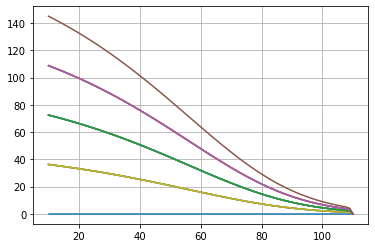

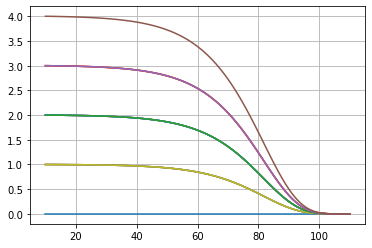

In [2]:
Tontine(4)

Plot DK
Plot CF


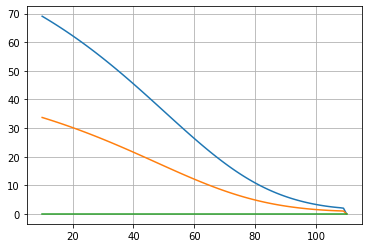

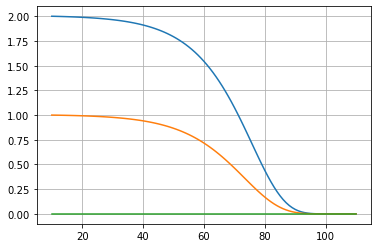

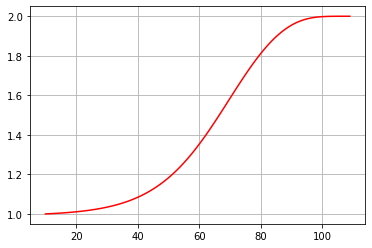

In [3]:
Tontine2(2)


Plot DK
Plot CF


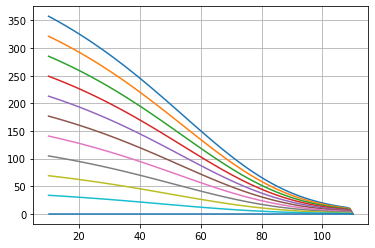

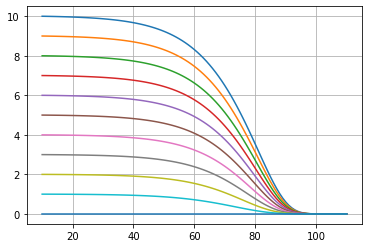

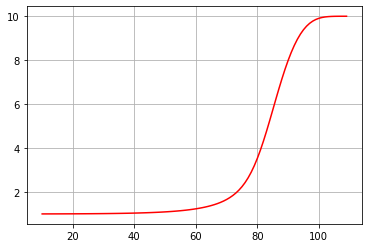

In [4]:
Tontine2(10)

Plot DK
Plot CF


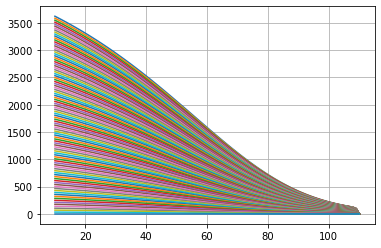

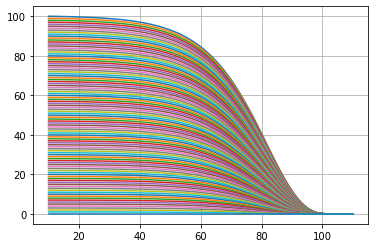

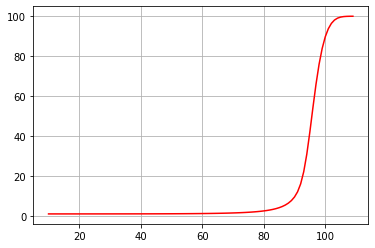

In [5]:
Tontine2(100)